In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/clients/customers.csv
/kaggle/input/customer-transactions/transactions.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Introduction

Marketing team of a bicycle shop is looking to boost business by analysing their existing customer dataset to determine customer trends and behaviour. Build a recommandetion that shows which of the 1000 new customers should be targeted to drive the most profit for the shop. 

In building this recommendation, there will be 3 steps: data exploration, model development and interpretation. 
I will use source external data from the ABS / Census to add additional variables that reveal more information about customers.

In [3]:
customer = pd.read_csv('../input/clients/customers.csv')
transaction = pd.read_csv('../input/customer-transactions/transactions.csv')

# Feature Engieneering 

I will drop unnecesary columns.

In [4]:
customer = customer.drop( labels = ['Unnamed: 0'], axis = 1)
transaction = transaction.drop( labels = ['Unnamed: 0'], axis = 1)

I will correct some wrong data type formats.

In [5]:
customer[['birth_date']] = pd.to_datetime(customer['birth_date'])

I will add new column called Age

In [6]:
customer.birth_date

0      1953-10-12
1      1980-12-16
2      1961-10-03
3      1977-05-13
4      1966-09-16
          ...    
4991   1959-10-07
4992   2001-10-17
4993   1954-10-05
4994   1952-12-17
4995   1955-10-02
Name: birth_date, Length: 4996, dtype: datetime64[ns]

In [7]:
customer['age'] = np.nan

In [8]:
current_year = pd.Timestamp.now().year
for index, row in customer.iterrows():
    customer.age[index] = current_year - customer.birth_date[index].year


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


I just find some duplicates values in state attribute from customer data set.

In [9]:
customer.state.value_counts()

NSW                2558
VIC                1205
QLD                1065
New South Wales      86
Victoria             82
Name: state, dtype: int64

## Create dataset with new customers

In [10]:
customer.state = customer.state.replace(to_replace='NSW', value = 'New South Wales')
customer.state = customer.state.replace(to_replace='QLD', value = 'Queensland')
customer.state = customer.state.replace(to_replace='VIC', value = 'Victoria')

In [11]:
newCustomer = customer.loc[ customer.customer_id > 4003].reset_index()
customer = customer.loc[ customer.customer_id < 4003]

## Missing value treatment

If a small number of values are missing I will drop those rows. Else, if it's a core field and if it's a numeric variable, I will impute missing values based on the distribution. To sample from a distribution of existing values, first I need to know the distribution. 

In [12]:
customer.isnull().sum()

customer_id                              0
first_name                               0
last_name                              125
gender                                   0
past_3_years_bike_related_purchases      0
birth_date                              88
job_title                              504
job_industry_category                  655
wealth_segment                           0
deceased_indicator                       0
owns_car                                 0
tenure                                  87
address                                  0
postcode                                 0
state                                    0
country                                  0
property_valuation                       0
age                                     88
dtype: int64

Gender, birth_date and tenure are core fields and 2.2% of the records are for these attributes are empty, so I will drop rows with empty values. The shape of the table before removing missing values was 3996 rows and after is 3908, so I removed 2.2% of the rows int he table.

In [13]:
print('percent of missing values {} %'.format(88/ customer.shape[0] * 100))
print('shape before treatment', customer.shape)

percent of missing values 2.2022022022022023 %
shape before treatment (3996, 18)


In [14]:
customer = customer.dropna( axis = 0, subset=['gender', 'birth_date', 'tenure'])
print('shape after treatment', customer.shape)

shape after treatment (3908, 18)


I will verify again fileds with missing values.

In [15]:
customer.isnull().sum()

customer_id                              0
first_name                               0
last_name                              121
gender                                   0
past_3_years_bike_related_purchases      0
birth_date                               0
job_title                              495
job_industry_category                  655
wealth_segment                           0
deceased_indicator                       0
owns_car                                 0
tenure                                   0
address                                  0
postcode                                 0
state                                    0
country                                  0
property_valuation                       0
age                                      0
dtype: int64

Last name is not a core field so I won't impute based on distribution. 
Job title and job industry are categorical values, so I will label missing values.

In [16]:
print('missing values in job_title {} %'.format( 495 / customer.shape[0]* 100))
print('missing values in job_category {} %'.format( 655 / customer.shape[0]* 100))

missing values in job_title 12.66632548618219 %
missing values in job_category 16.760491299897645 %


In [17]:
customer.job_title = customer.job_title.replace( np.nan, 'No job')
customer.job_industry_category = customer.job_industry_category.replace( np.nan, 'No industry category')

# Data exploration

## Customer profile

All customers live in Australia. Most of the customers live in New South Wales, are mass consumer, female and work in Manufacturing or Financial Services and are aged around 40.

Text(0.5, 0.98, 'Customer profile')

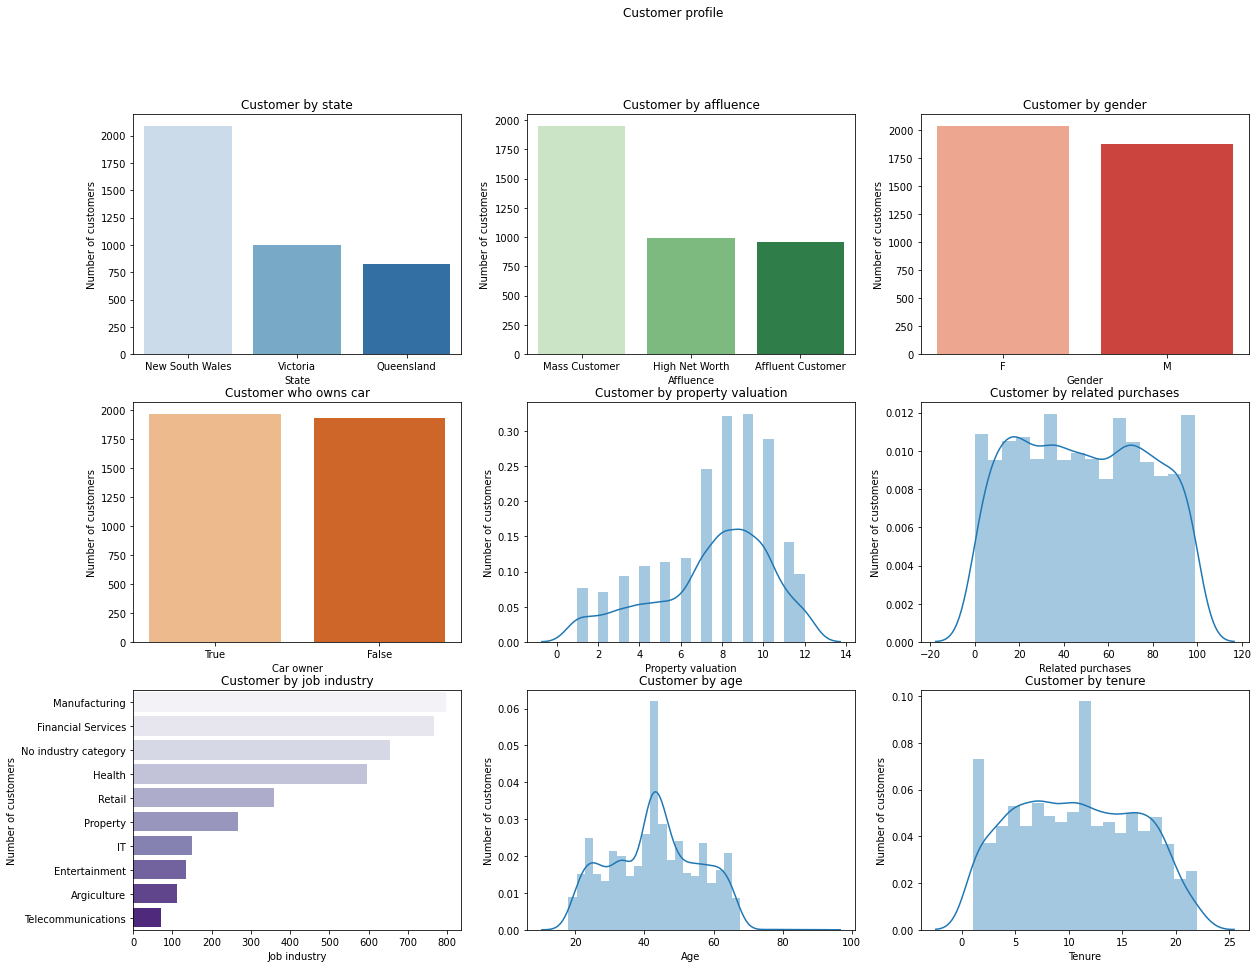

In [18]:
fig, axs = plt.subplots(3, 3, figsize = (20, 15))

sns.countplot(x = 'state', data = customer, ax = axs[0][0], palette="Blues", order = customer['state'].value_counts().index)
axs[0][0].set_title('Customer by state')
axs[0][0].set_xlabel('State')
axs[0][0].set_ylabel('Number of customers')


sns.countplot(x = 'wealth_segment', data = customer, ax = axs[0][1], palette="Greens", order = customer['wealth_segment'].value_counts().index)
axs[0][1].set_title('Customer by affluence')
axs[0][1].set_xlabel('Affluence')
axs[0][1].set_ylabel('Number of customers')

sns.countplot(x = 'gender', data = customer, ax = axs[0][2], palette="Reds", order = customer['gender'].value_counts().index)
axs[0][2].set_title('Customer by gender')
axs[0][2].set_xlabel('Gender')
axs[0][2].set_ylabel('Number of customers')

sns.countplot(x = 'owns_car', data = customer, ax = axs[1][0], palette="Oranges", order = customer['owns_car'].value_counts().index)
axs[1][0].set_title('Customer who owns car')
axs[1][0].set_xlabel('Car owner')
axs[1][0].set_ylabel('Number of customers')

sns.distplot( customer.property_valuation, ax = axs[1][1])
axs[1][1].set_title('Customer by property valuation')
axs[1][1].set_xlabel('Property valuation')
axs[1][1].set_ylabel('Number of customers')

sns.distplot( customer.past_3_years_bike_related_purchases, ax = axs[1][2])
axs[1][2].set_title('Customer by related purchases')
axs[1][2].set_xlabel('Related purchases')
axs[1][2].set_ylabel('Number of customers')

sns.countplot(y = 'job_industry_category', data = customer, ax = axs[2][0], palette="Purples", order = customer['job_industry_category'].value_counts().index)
axs[2][0].set_title('Customer by job industry')
axs[2][0].set_xlabel('Job industry')
axs[2][0].set_ylabel('Number of customers')

sns.distplot( customer.age, ax = axs[2][1])
axs[2][1].set_title('Customer by age')
axs[2][1].set_xlabel('Age')
axs[2][1].set_ylabel('Number of customers')

sns.distplot( customer.tenure, ax = axs[2][2])
axs[2][2].set_title('Customer by tenure')
axs[2][2].set_xlabel('Tenure')
axs[2][2].set_ylabel('Number of customers')

fig.suptitle('Customer profile')

## Customers by gender and affluence

Most of the customer, both female or male are mass customers.

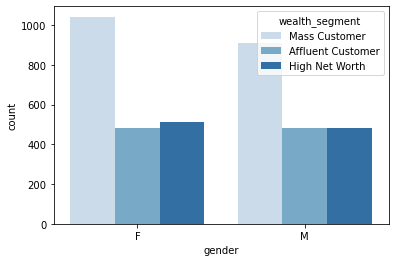

In [19]:
sns.countplot( x = 'gender', hue = 'wealth_segment', data = customer,  palette = 'Blues')

## Customers by gender and car posesion

More males then females own a car.

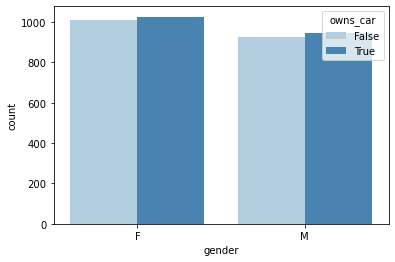

In [20]:
sns.countplot( x = 'gender', hue = 'owns_car', data = customer,  palette = 'Blues')


## Customers by job industry and gender

In all industries are more females than males, this may be due to a larger number of females than males overall.

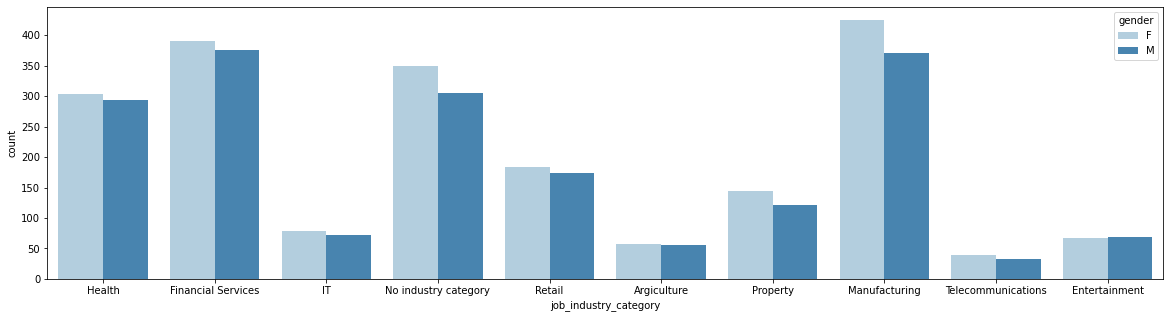

In [21]:
fig, ax = plt.subplots( figsize = (20, 5))
sns.countplot( x = 'job_industry_category', hue = 'gender', data = customer,ax = ax, palette = 'Blues')

## Customers by gender and age

The distribution of age is the same for both females and males.

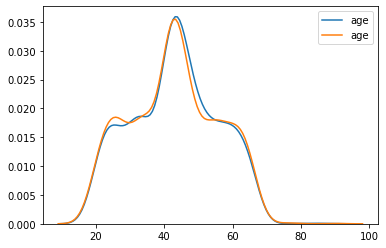

In [22]:
females = customer[ customer.gender == 'F']
males = customer[ customer.gender == 'M']

sns.kdeplot( data = females.age, legend = 'females')
sns.kdeplot( data = males.age, legend = 'males')

# Transactions

## Sales over time

The trend of sales is contant during January 2017 and  December 2017.

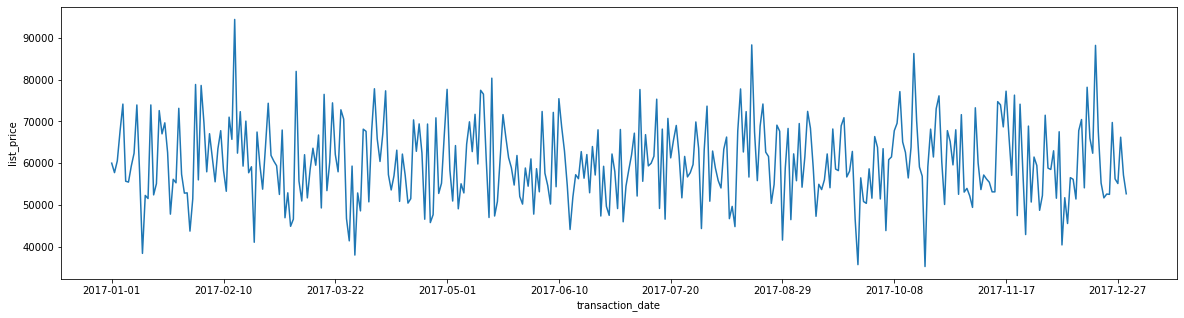

In [23]:
sales = transaction.groupby('transaction_date', as_index = False).list_price.sum()
fig, ax = plt.subplots( figsize = (20, 5))
sns.lineplot( x = 'transaction_date', y = 'list_price', data = sales, ax = ax)
ax.xaxis.set_major_locator(ticker.MaxNLocator(12))

## Online transactions 

The number of online transactions is almost equal with the number of store transactions.

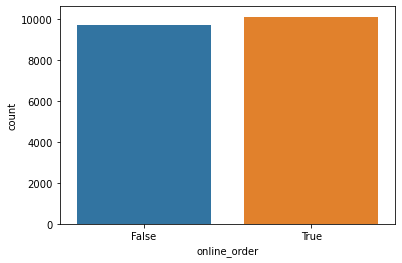

In [24]:
sns.countplot( x = 'online_order', data = transaction)

## Best selled brands by product class

Solex is the best selled bicycle brand. The best selled bicycles are those from a medium class.

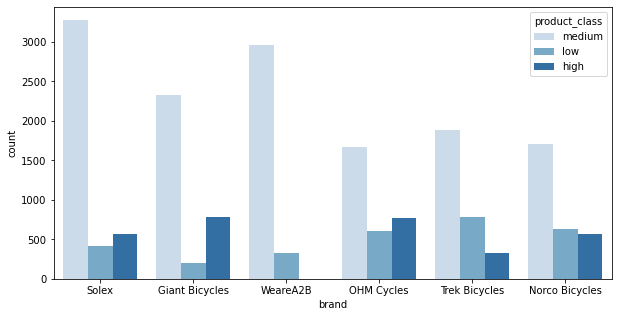

In [25]:
fig, ax = plt.subplots( figsize = (10, 5))
sns.countplot( x = 'brand', data = transaction, hue = 'product_class', ax = ax, palette = 'Blues', order = transaction['brand'].value_counts().index)

## Profit over time

I will add a new column called profit obtained using using diffrence between list price and standard cost.

Profit is constant over time with a big spike in December.

In [26]:
transaction['profit'] = transaction['list_price'] - transaction ['standard_cost']

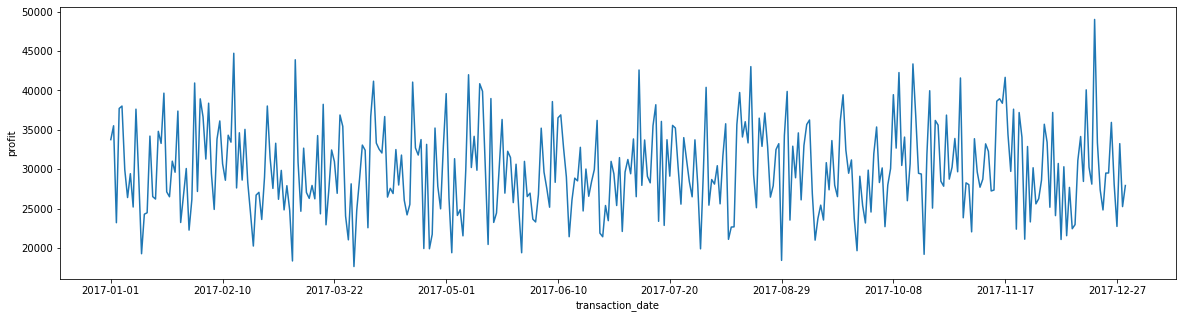

In [27]:
profit = transaction.groupby('transaction_date', as_index  = False).profit.sum()
fig, ax = plt.subplots( figsize = (20, 5))
sns.lineplot( x = 'transaction_date', y = 'profit', data = profit, ax = ax)
ax.xaxis.set_major_locator(ticker.MaxNLocator(12))

## Profit by brand 

Much of the profit comes from the selling of bicycles with product class: medium & brand: WeareA2B. This may be due to the fact that best selled bicycles are those with a product class: medium. 

But best selled bicycles are Solex & product class: medium. This means that brand WeareA2B brings more profit than brand Solex, even if the number of selled bicycles with brand WeareA2B is smaller.

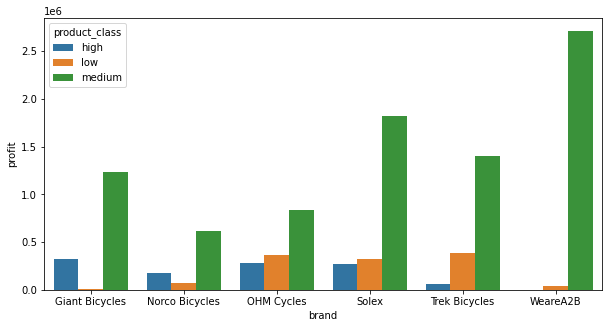

In [28]:
profit_by_brand_and_product_class = transaction.groupby(['brand', 'product_class'], as_index = False).profit.sum()
fig, ax = plt.subplots( figsize = (10, 5))
sns.barplot( x = 'brand', y = 'profit', hue = 'product_class', data = profit_by_brand_and_product_class, ax = ax)

## Profit by product line and product size

Much of the profit comes from standard bicycles with the size medium. These may be due to the fact that standard bicycles are the most versatile.

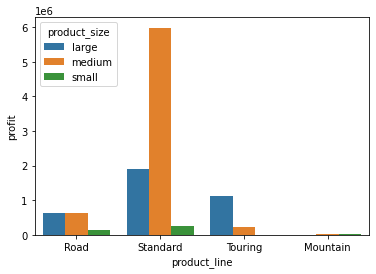

In [29]:
profit_by_product_line_and_product_size = transaction.groupby(['product_size', 'product_line'], as_index = False).profit.sum()
profit_by_product_line_and_product_size
sns.barplot( x = 'product_line', y = 'profit', hue = 'product_size', data = profit_by_product_line_and_product_size)

# Merge of the 2 datasets : transaction and customer

In [30]:
dataset = transaction.merge( customer, on = 'customer_id', suffixes=['_customer', '_transaction'])
dataset

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,...,wealth_segment,deceased_indicator,owns_car,tenure,address,postcode,state,country,property_valuation,age
0,1,2,2950,2017-02-25,False,Approved,Solex,Standard,medium,medium,...,Mass Customer,False,True,10.0,984 Hoepker Court,3064,Victoria,Australia,6,65.0
1,11065,1,2950,2017-10-16,False,Approved,Giant Bicycles,Standard,medium,medium,...,Mass Customer,False,True,10.0,984 Hoepker Court,3064,Victoria,Australia,6,65.0
2,18923,62,2950,2017-04-26,False,Approved,Solex,Standard,medium,medium,...,Mass Customer,False,True,10.0,984 Hoepker Court,3064,Victoria,Australia,6,65.0
3,2,3,3120,2017-05-21,True,Approved,Trek Bicycles,Standard,medium,large,...,Mass Customer,False,True,10.0,4 Shopko Circle,2196,New South Wales,Australia,5,41.0
4,6862,4,3120,2017-10-05,False,Approved,Giant Bicycles,Standard,high,medium,...,Mass Customer,False,True,10.0,4 Shopko Circle,2196,New South Wales,Australia,5,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19322,18735,45,3168,2017-02-21,True,Approved,Solex,Standard,medium,medium,...,Affluent Customer,False,False,22.0,88 Rutledge Crossing,4215,Queensland,Australia,7,44.0
19323,18789,83,3168,2017-04-11,False,Approved,Solex,Touring,medium,large,...,Affluent Customer,False,False,22.0,88 Rutledge Crossing,4215,Queensland,Australia,7,44.0
19324,19113,3,3168,2017-06-03,False,Approved,Trek Bicycles,Standard,medium,large,...,Affluent Customer,False,False,22.0,88 Rutledge Crossing,4215,Queensland,Australia,7,44.0
19325,19912,3,3168,2017-09-30,False,Approved,Trek Bicycles,Standard,medium,large,...,Affluent Customer,False,False,22.0,88 Rutledge Crossing,4215,Queensland,Australia,7,44.0


I will check if there are transactions without a coresponding customer or  customers without a coreponding transaction. Transaction dataset has 476 more rows than the final dataset, this means there are customers without a coresponding transaction.

In [31]:
print('customer shape : ', customer.shape[0])
print('transaction shape : ', transaction.shape[0])

customer shape :  3908
transaction shape :  19803


## Profit by gender and affluence

Much of the profit comes from custmer with gender female and are mass consumer.

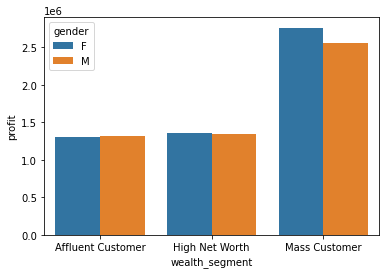

In [32]:
profit_by_gender_and_affluence = dataset.groupby(['gender', 'wealth_segment'], as_index = False).profit.sum()
sns.barplot( x = 'wealth_segment', y = 'profit', hue = 'gender', data = profit_by_gender_and_affluence)

## Profit by brand and affluence

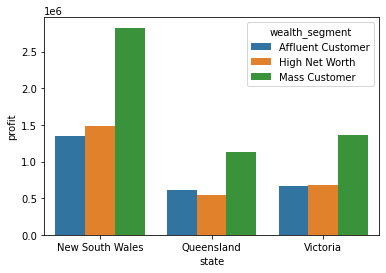

In [33]:
profit_by_brand_productline_and_affluence = dataset.groupby(['state', 'wealth_segment'], as_index = False).profit.sum()
sns.barplot( x = 'state', y = 'profit', hue = 'wealth_segment', data = profit_by_brand_productline_and_affluence)

## Correlation coeficient

Correlogram shows a direct, strong relationship between tenure and age, that the older the customer the greater tenure has. Also, it's a direct relationship between cost and price, because price is computed depending on the cost of production. Correlogram also shows a strong, negative relationship between profit and standard cost, this means products with high production cost drive less profit.

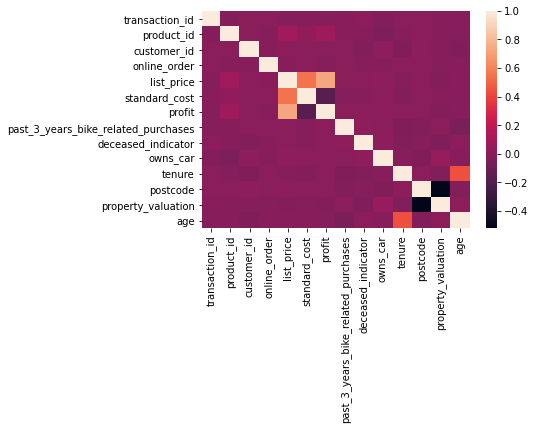

In [34]:
corr = dataset.corr()
sns.heatmap(corr)

In [35]:
dataset

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,...,wealth_segment,deceased_indicator,owns_car,tenure,address,postcode,state,country,property_valuation,age
0,1,2,2950,2017-02-25,False,Approved,Solex,Standard,medium,medium,...,Mass Customer,False,True,10.0,984 Hoepker Court,3064,Victoria,Australia,6,65.0
1,11065,1,2950,2017-10-16,False,Approved,Giant Bicycles,Standard,medium,medium,...,Mass Customer,False,True,10.0,984 Hoepker Court,3064,Victoria,Australia,6,65.0
2,18923,62,2950,2017-04-26,False,Approved,Solex,Standard,medium,medium,...,Mass Customer,False,True,10.0,984 Hoepker Court,3064,Victoria,Australia,6,65.0
3,2,3,3120,2017-05-21,True,Approved,Trek Bicycles,Standard,medium,large,...,Mass Customer,False,True,10.0,4 Shopko Circle,2196,New South Wales,Australia,5,41.0
4,6862,4,3120,2017-10-05,False,Approved,Giant Bicycles,Standard,high,medium,...,Mass Customer,False,True,10.0,4 Shopko Circle,2196,New South Wales,Australia,5,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19322,18735,45,3168,2017-02-21,True,Approved,Solex,Standard,medium,medium,...,Affluent Customer,False,False,22.0,88 Rutledge Crossing,4215,Queensland,Australia,7,44.0
19323,18789,83,3168,2017-04-11,False,Approved,Solex,Touring,medium,large,...,Affluent Customer,False,False,22.0,88 Rutledge Crossing,4215,Queensland,Australia,7,44.0
19324,19113,3,3168,2017-06-03,False,Approved,Trek Bicycles,Standard,medium,large,...,Affluent Customer,False,False,22.0,88 Rutledge Crossing,4215,Queensland,Australia,7,44.0
19325,19912,3,3168,2017-09-30,False,Approved,Trek Bicycles,Standard,medium,large,...,Affluent Customer,False,False,22.0,88 Rutledge Crossing,4215,Queensland,Australia,7,44.0
